### Importing Libraries

In [1]:
import math
import numpy as np
import pandas as pd
import time
from sklearn.svm import SVC
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import cv2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [2]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

### Importing Dataset

In [3]:
df = pd.read_csv('fer2013.csv')

In [4]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [6]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

### Visualize Dataset

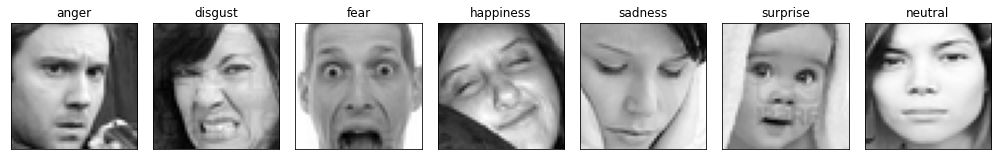

In [7]:
fig = plt.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(1):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px , cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        plt.tight_layout()

### Input and Output Data

In [8]:
X = df.pixels.apply(lambda x: np.array(x.split(' ')).astype('float32'))
X = np.stack(X, axis=0)
Y = np.array(df['emotion'])

In [9]:
X.shape

(35887, 2304)

In [10]:
Y.shape

(35887,)

#### Confusion Matrix

In [11]:
# Plot confusion matrix 

import seaborn as sns
import matplotlib.pyplot as plt

def create_confmat(true_labels, predicted_labels, columns, colour = 'Greens', size = (20,14)):
    sns.set(font_scale=1.5)
    cm = confusion_matrix(true_labels, predicted_labels) 
    cm_df = pd.DataFrame(cm,
    index = [col for col in columns], 
    columns = [col for col in columns])
    plt.figure(figsize=(18,16))
    sns.heatmap(cm_df, annot = True, cmap = colour, fmt='g', linewidths=.2)
    plt.title('Confusion Matrix', fontsize = 20)
    plt.ylabel('True label', fontsize = 18)
    plt.xlabel('Predicted label', fontsize = 18)
    plt.tick_params(axis='both', labelsize=14)
    plt.show()

### Train and Test Split for KNN and SVM


In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y,
                                                    shuffle=True, stratify=Y,
                                                    test_size=0.2, random_state=2)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((28709, 2304), (7178, 2304), (28709,), (7178,))

###PCA to retain 95% variation and reduce dataset size

In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.astype(np.float32))
X_valid = scaler.transform(X_valid.astype(np.float32))
pca = PCA(n_components=.95)
pca.fit(X_train)
X_test_p = pca.transform(X_valid)
X_train_p = pca.transform(X_train)
scaler = StandardScaler()
X_train_p = scaler.fit_transform(X_train_p.astype(np.float32))
X_test_p = scaler.transform(X_test_p.astype(np.float32))
X_train_p.shape ,X_test_p.shape 


((28709, 269), (7178, 269))

# SVM

####Using Linear kernel

In [14]:
model = SVC(kernel = 'linear')
model.fit(X_train_p,y_train)
model.score(X_test_p , y_valid)

0.37350236834772915

####Using rbf kernel

In [15]:
model = SVC(kernel ='rbf')
model.fit(X_train_p,y_train)
model.score(X_test_p , y_valid)

0.4612705488994149

# KNN

In [16]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=1)
classifier.fit(X_train, y_train)
classifier.score(X_valid,y_valid)

0.406241292839231

In [17]:
start_time = time.time()
y_pred = classifier.predict(X_valid)
print("Time Taken : %s seconds " % (time.time() - start_time))

Time Taken : 5.293350696563721 seconds 


In [19]:
cnt = 0
for i in range(X_valid.shape[0]):
    cnt += y_pred[i] == y_valid[i]
print("Accuracy :", cnt/X_valid.shape[0]*100, "%")

Accuracy : 40.6241292839231 %


####KNN using default parameters

In [20]:
knn = KNeighborsClassifier()
knn.fit(X_train_p ,y_train)
knn.score(X_test_p,y_valid)

0.269573697408749